In [50]:
import numpy as np

np.random.seed(42)

T, N = 200, 100
dx, dz, dy, K = 3, 3, 3, 1   # covariates=3, latent=3, response=3, 1 component

X = np.random.randn(T, N, dx)        # covariates
Z = np.zeros((T, N, dz))             # latent (iid per observation)
Y = np.zeros((T, N, dy))             # response
labels = np.zeros((T, N), dtype=int) # always 0 now

# random weights for one component
u = np.random.randn(dx+dz)
v = np.random.randn(dx+dz)
w = np.random.randn(dx+dz)
d = np.random.randn(dx+dz)


import numpy as np

def generate_data(X, mean_func, sigma_func, change_points=[100], z_means=[0, 5]):
    """
    Generate time series data with latent Z and multiple change points.

    Parameters
    ----------
    X : np.ndarray
        Covariates, shape (T, N, dx)
    mean_func : callable
        Function mean_func(h, z) -> (dy,)
    sigma_func : callable
        Function sigma_func(h, z) -> (dy,)
    change_points : list of int, default=[100]
        Time indices where Z distribution changes
    z_means : list of float, default=[0, 5]
        Mean of Z distribution in each segment. 
        Length must be len(change_points)+1.

    Returns
    -------
    X : np.ndarray (T, N, dx)
    Y : np.ndarray (T, N, dy)
    Z : np.ndarray (T, N, dz)
    """
    T, N, dx = X.shape
    dz = 3
    test_h = np.concatenate([X[0,0], np.zeros(dz)])
    dy = mean_func(test_h, np.zeros(dz)).shape[0]

    if len(z_means) != len(change_points) + 1:
        raise ValueError("len(z_means) must equal len(change_points)+1")

    Z = np.zeros((T, N, dz))
    Y = np.zeros((T, N, dy))

    cps = [0] + change_points + [T]

    for seg in range(len(cps)-1):
        mu_z = z_means[seg]
        for t in range(cps[seg], cps[seg+1]):
            for n in range(N):
                z = np.random.normal(mu_z, 1, dz)
                Z[t,n] = z
                h = np.concatenate([X[t,n], z])
                mu = mean_func(h, z)
                sigma = sigma_func(h, z)
                Y[t,n] = np.random.normal(mu, sigma)

    return X, Y, Z




In [51]:
np.random.seed(42)

def mean_func(h, z):
    return np.array([
        np.tanh(h @ u) + z[0],
        np.sin(h @ v) + z[1],
        0.5*(h @ w) - z[2]
    ])

def sigma_func(h, z):
    val = 0.1 * abs(h @ d) + 0.01 * abs(z[0])
    sigma = 0.1 + 0.1 * np.tanh(val) + abs(z[0])*0.5
    return sigma * np.ones(dy)
T, N, dx, dz, dy = 200, 50, 3, 3, 3
X = np.random.randn(T, N, dx)
X_out_1, Y_out_1, Z_out_1 = generate_data(X, mean_func, sigma_func, change_points=[50,100,150], z_means=[0,1,-1,-2])

def mean_func(h, z):
    return np.array([
        np.tanh(h @ u) + z[0]+3,
        np.sin(h @ v) - z[1]+3,
        0.5*(h @ w) + z[2] + 3
    ])
T, N, dx, dz, dy = 200, 30, 3, 3, 3
X = np.random.randn(T, N, dx)
X_out_2, Y_out_2, Z_out_2 = generate_data(X, mean_func, sigma_func, change_points=[50,100,150], z_means=[0,1,-1,-2])

def mean_func(h, z):
    return np.array([
        np.tanh(h @ u) - z[0]-3,
        np.sin(h @ v) + z[1]-3,
        0.5*(h @ w) + z[2] - 3
    ])
T, N, dx, dz, dy = 200, 20, 3, 3, 3
X = np.random.randn(T, N, dx)
X_out_3, Y_out_3, Z_out_3 = generate_data(X, mean_func, sigma_func, change_points=[50,100,150], z_means=[0,1,-1,-2])

X_all = np.concatenate([X_out_1, X_out_2, X_out_3], axis=1)
Y_all = np.concatenate([Y_out_1, Y_out_2, Y_out_3], axis=1)
Z_all = np.concatenate([Z_out_1, Z_out_2, Z_out_3], axis=1)

N1, N2, N3 = 50, 30, 20

labels = np.concatenate([
    np.zeros(N1, dtype=int),    
    np.ones(N2, dtype=int),        
    np.full(N3, 2, dtype=int)   
])

print("X_all:", X_all.shape)
print("Y_all:", Y_all.shape)
print("Z_all:", Z_all.shape)



X_all: (200, 100, 3)
Y_all: (200, 100, 3)
Z_all: (200, 100, 3)


In [52]:
import numpy as np
import pandas as pd
import os


os.makedirs("./sim_data", exist_ok=True)

def save_array(arr, name):

    T, N, D = arr.shape
    time_idx = np.repeat(np.arange(T), N)          # (T*N,)
    sample_idx = np.tile(np.arange(N), T)          # (T*N,)
    flat = arr.reshape(T*N, D)                     # (T*N, D)

    df = pd.DataFrame(flat, columns=[f"dim{j+1}" for j in range(D)])
    df.insert(0, "sample", sample_idx)
    df.insert(0, "time", time_idx)
    
    out_path = f"./sim_data/{name}.csv"
    df.to_csv(out_path, index=False)
    print(f"Saved {out_path}, shape={df.shape}")


save_array(X_all, "x_all_3cp_test")
save_array(Y_all, "y_all_3cp_test")
save_array(Z_all, "z_all_3cp_test")


Saved ./sim_data/x_all_3cp_test.csv, shape=(20000, 5)
Saved ./sim_data/y_all_3cp_test.csv, shape=(20000, 5)
Saved ./sim_data/z_all_3cp_test.csv, shape=(20000, 5)


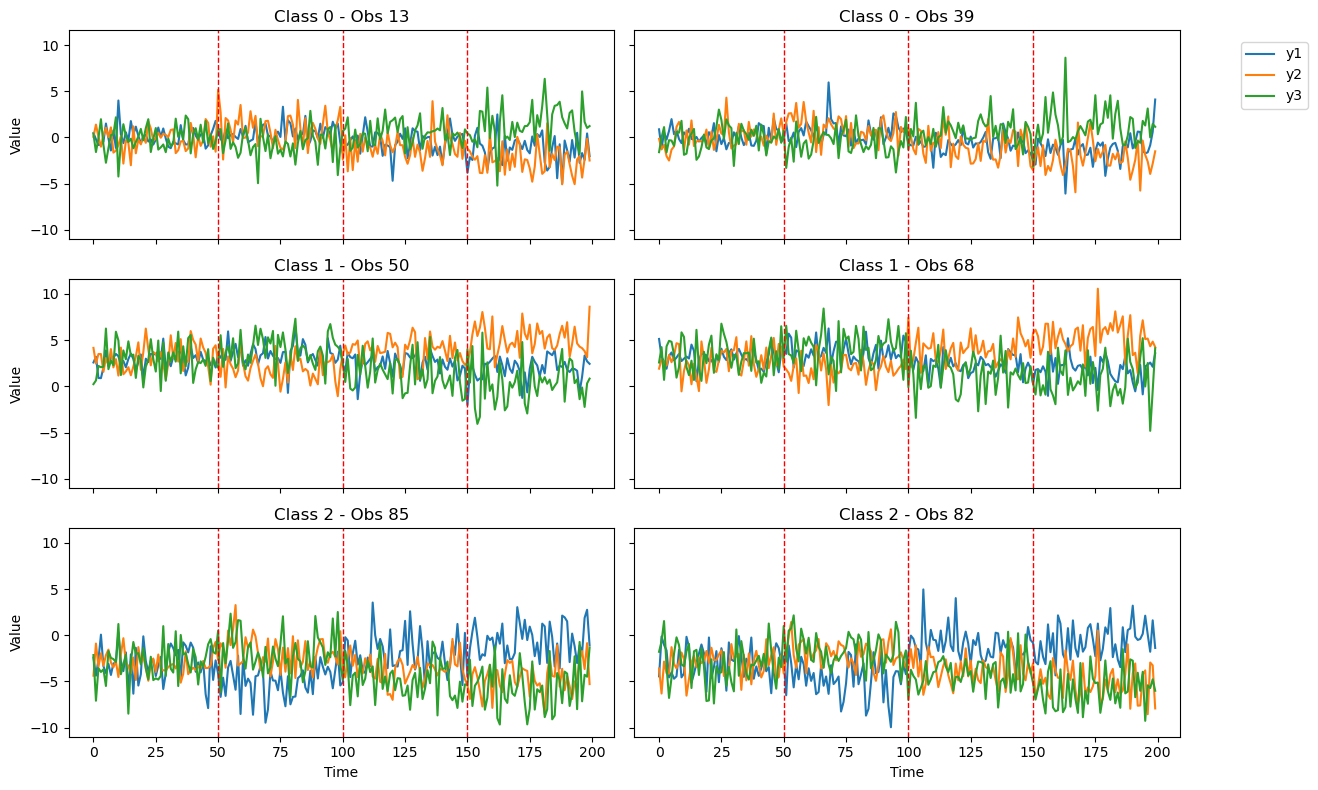

In [53]:
import numpy as np
import matplotlib.pyplot as plt

T, N, dy = Y_all.shape  # (200, 100, 3)
N1, N2, N3 = 50, 30, 20
labels = np.concatenate([
    np.zeros(N1, dtype=int),
    np.ones(N2, dtype=int),
    np.full(N3, 2, dtype=int)
])

np.random.seed(42)
chosen_idx = {c: np.random.choice(np.where(labels==c)[0], size=2, replace=False) 
              for c in np.unique(labels)}

colors_y = ['tab:blue', 'tab:orange', 'tab:green'] 
time = np.arange(T)
change_points = [50, 100, 150]

fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True, sharey=True)

for row, c in enumerate(np.unique(labels)):
    for col, idx in enumerate(chosen_idx[c]):
        ax = axes[row, col]
        for j in range(dy):
            ax.plot(time, Y_all[:, idx, j], label=f"y{j+1}", color=colors_y[j])

        for cp in change_points:
            ax.axvline(cp, color="red", linestyle="--", linewidth=1)
        ax.set_title(f"Class {c} - Obs {idx}")
        if col == 0:
            ax.set_ylabel("Value")

for ax in axes[-1, :]:
    ax.set_xlabel("Time")

handles, labels_leg = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels_leg, loc="upper right", bbox_to_anchor=(1.1, 0.95))

plt.tight_layout()
plt.show()



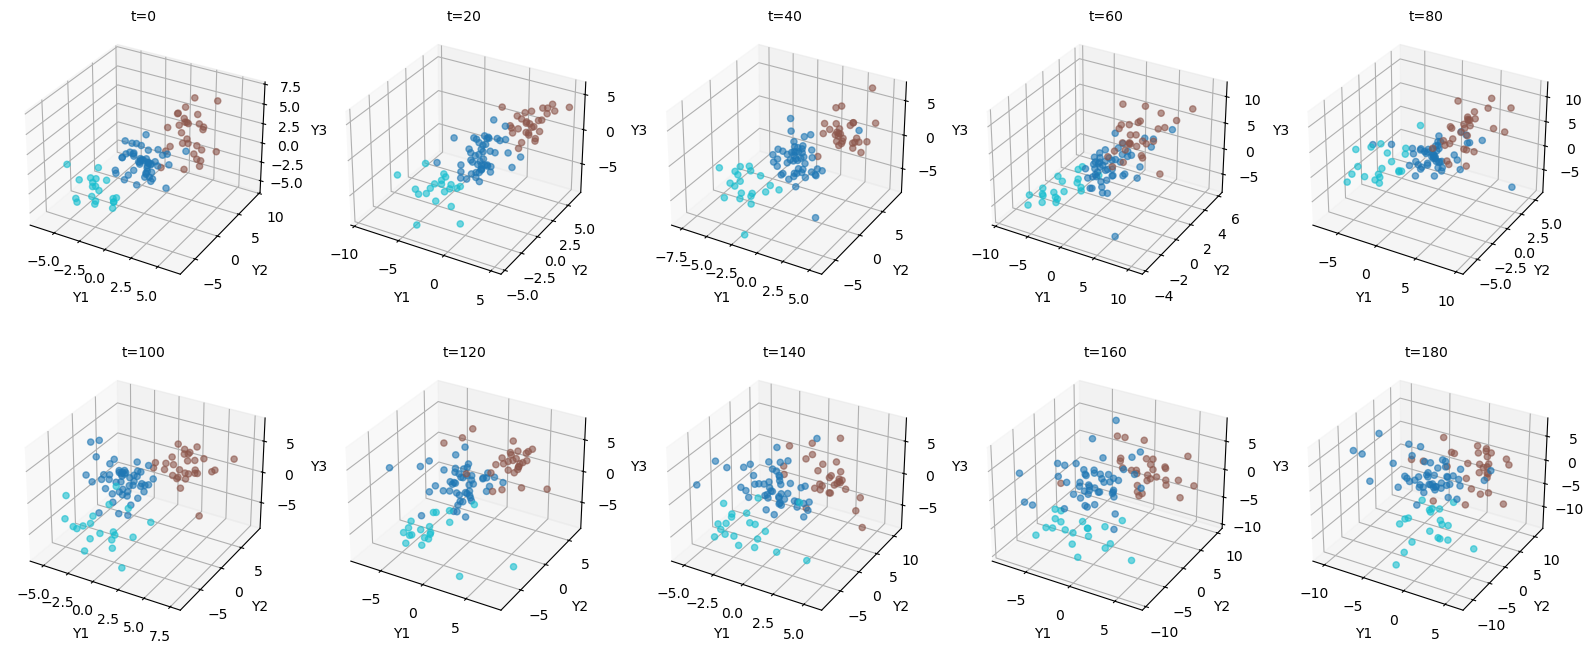

In [45]:
y_seq = Y_all.reshape(T, N, dy)


labels = np.concatenate([
    np.zeros(N1, dtype=int),
    np.ones(N2, dtype=int),
    np.full(N3, 2, dtype=int)
])


colors = plt.cm.tab10(np.linspace(0, 1, len(np.unique(labels))))


time_points = np.arange(0, T, 20)   # 0,20,...,180
nplots = len(time_points)
ncols = 5
nrows = int(np.ceil(nplots/ncols))


fig = plt.figure(figsize=(4*ncols, 4*nrows))

for i, t in enumerate(time_points):
    ax = fig.add_subplot(nrows, ncols, i+1, projection='3d')

    for c in np.unique(labels):
        mask = (labels == c)
        xs, ys, zs = y_seq[t, mask, 0], y_seq[t, mask, 1], y_seq[t, mask, 2]
        ax.scatter(xs, ys, zs, color=colors[c], alpha=0.6, s=20)

    ax.set_title(f"t={t}", pad=1, fontsize=10)

    ax.set_xlabel("Y1")
    ax.set_ylabel("Y2")
    ax.set_zlabel("Y3")